# Nursing Data Analysis

###### Tae Ken Kim

Say that you are a government official at some US state, and you are interested in getting more Registered Nurses for your state. American Association of Colleges of Nursing, "U.S. is projected to experience a shortage of Registered Nurses (RNs) that is expected to intensify as Baby Boomers age and the need for health care grows" (1). Using publicly availiable data, lets develope some insights into the nursing shortage that will help formulate a plan of action to boost the number of nurses in a US state.


(1):https://www.aacnnursing.org/news-information/fact-sheets/nursing-shortage

## National Sample Survey of Registered Nurses (NSSRN)

The main dataset we will be using is the NSSRN, published by Bureau of Health Workforce, a US government entity under Health Resources & Services Administration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyreadstat
import seaborn as sns
import math
import copy
from time import sleep
from tqdm import tqdm
import random
import scipy.stats as stats
from state_name import census_and_regions
import pickle
import dill
import spacy
import pymc3 as pm
import theano.tensor as tt
import requests
import bs4
from bs4 import BeautifulSoup
from time import sleep
import webbrowser
from nordvpn_switcher import initialize_VPN,rotate_VPN,terminate_VPN


In [2]:
[state_census, region] = census_and_regions()
df_2018, meta_2018 = pyreadstat.read_sas7bdat('NSSRN2018_SAS_encoded_package\\NSSRN_2018_PUF.sas7bdat')
weight = df_2018['RKRNWGTA']

In [19]:
#function to handle region to state, and vice versa
def r2s(dict_in):
    dict_out = copy.deepcopy(dict_in)
    for key in dict_in.keys():
        if key in region:
            for st in region[key]:
                dict_out[st] = dict_in[key]
            dict_out.pop(key)
    return dict_out
            
def s2r(dict_in):
    dict_out = copy.deepcopy(dict_in)
    for key in region:        
        dict_out[key] = np.mean([dict_in[st] for st in region[key]])
        for st in region[key]:
            dict_out.pop(st)
    return dict_out

def region_explain():
    print(' ')
    print('(D1: VT, RI     D2: ND,SD      D8: MT, WY     D9: HI, AK)')
    
#function that takes region, and gives back state names
def r2slist(st):
    if st in region:
        return region[st]
    else:
        return [st]
    
def slist2r(st):
    for key in region:
        if st in region[key]:
            return key

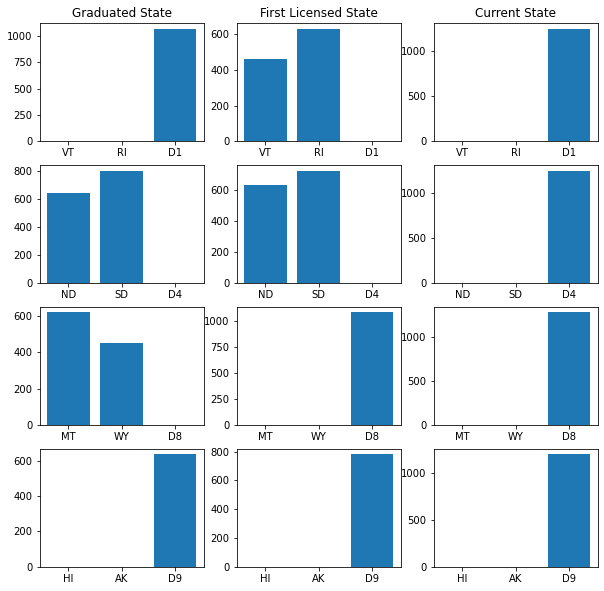

In [4]:
titles=['Graduated State', 'First Licensed State', 'Current State']
varnames=['ED_NDLOC_ST_PUF','ED_FRN_ST_PUF','PN_LOC_ST_PUF']
fig, ax = plt.subplots(4,3,figsize=(10,10))
for vi, vn in enumerate(varnames):    
    region_plots=[]
    for key in list(region.keys()):
        temp=[df_2018[df_2018[vn]==st].shape[0] for st in region[key]]
        temp.append(df_2018[df_2018[vn]==key].shape[0])
        region_plots.append(temp)
        
    
    for i in range(4):
        key = list(region.keys())[i]
        xlabel = copy.copy(region[key])
        xlabel.append(key)
        
        ax[i,vi].bar(xlabel,region_plots[i])
        
    ax[0,vi].set_title(titles[vi])

The dataframe "df_2018" will contain all of the survey data. We are interested in three measures: the graduated, first licensed, and currently practicing states of registered nurses.

Some of the survey results give aggregate regions rather than state level data (D1, D4, D8, D9), but it is not consistent in its reporting style. As we can see from the above graph, since current state is only reported at the regional level for these states, it makes sense to combine each region's data into one group for all states in the region.

States in D1(RI, VT), D4(ND, SD), and D8(MT, WY) are geographically close, so combining these states isn't too far-fetched. D9(AK, HI) states are only reported at the regional level for all three metrics so we have no other choice.

Now, AK and HI are obviously very different states, so any insights drawn from D9 might be useless. However, since we will be looking at the rates at which nurses enter and leave each state, and since they are both outside the contiguous United States, they will pose similar hurdles for people looking to transiton in/out of these states. Therefore, the insights drawn from D9 data might still prove useful.

In [5]:
for key in region.keys():
    for st in region[key]:
        for vn in varnames:
            df_2018.loc[df_2018[vn]==st,vn]=key

### Data Expoloration

There are two ways of increasing the number of nurses in a state.

1. Attract nurses from other states
2. Keep the nurses working in your state

We are limited in our data to graduation states, first licensed state, and current state; we can't track exact movement of nurses when they move to different states. However, we can plot the percentage of nurses who stayed in their first licensed state as a function of years worked. I am assuming that first licensed state is the state where each nurse had their first job, and ignoring nurses who retired, as the survey does not provide data on retired nurses(nurses not maintaining an active license).

Text(0, 0.5, 'Rate of change')

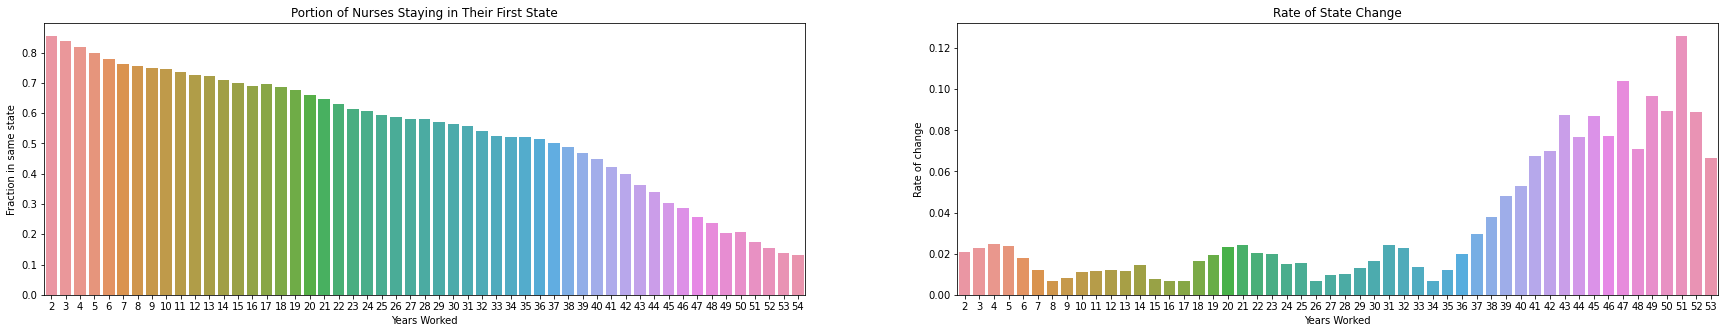

In [6]:
#check if first state and current state is the same. If one is a D region, use both. If one entry is .L, get rid of it
#1 = same, 0 = not same, -1 = omit
ss = np.zeros(df_2018.shape[0],dtype=int)
for i in range(len(ss)):
    
    cs= df_2018.PN_LOC_ST_PUF[i]  #current state
    fs =df_2018.ED_FRN_ST_PUF[i]
    
    #if(fs =='.L') or (cs=='.L'):    #check if they are still working
    if fs =='.L':
        ss[i] = -1
    elif fs == cs:
        ss[i] = 1
    elif (fs in region):
        if cs in region[fs]:
            ss[i] = 1
    elif(cs in region):
        if fs in region[cs]:
            ss[i] = 1
           
yrw = (2018-df_2018.ED_FRN_YR_PUF.astype('int')).to_numpy()
yb = pd.DataFrame({'years_worked':yrw,'same_state':ss,'weight':weight}).loc[lambda df:df['same_state']!=-1,:]

""""make histogram to explore data"""
hist_bins = np.zeros(yb.years_worked.unique().max())

for i in range(len(hist_bins)):
    tot = yb['weight'][yb['years_worked']==i].sum()
    ss = yb['weight'][(yb['years_worked']==i)&(yb['same_state']==1)].sum()
    if tot != 0:
        hist_bins[i] = ss/tot

from scipy.ndimage.filters import uniform_filter1d
y = uniform_filter1d(hist_bins[2:], size=5)
barplot_x = [str(int) for int in range(len(hist_bins))]
fig, ax = plt.subplots(1,2,figsize=(30,5))
sns.barplot(x=barplot_x[2:],y=y,ax=ax[0])
ax[0].set_title('Portion of Nurses Staying in Their First State')
ax[0].set_xlabel('Years Worked')
ax[0].set_ylabel('Fraction in same state')

ydiff = np.zeros(len(y)-1)
for i in range(len(ydiff)):
    ydiff[i] = (y[i]-y[i+1])/y[i]
yy = uniform_filter1d(ydiff, size=3)
sns.barplot(x=barplot_x[2:-1],y=yy,ax=ax[1])
ax[1].set_title('Rate of State Change')
ax[1].set_xlabel('Years Worked')
ax[1].set_ylabel('Rate of change')

We can see that once a nurse starts their career in a state, there is only around 2% chance each year that they will move to a different state for at least three decades. Therefore, the most effective way to increase the number of nurses is to **increase the number of first time nurses**. If we aim to recruit nurses with experience, we should **target nurses with about 4 years of experience**, as they are more likely to move states, and they have many years before retirement. By the same logic, **retainment efforts could be targeted towards the same group** to yield maximum benefit. For example, a state might offer a boost to the nursing salary(through tax credit, direct payments, etc) for nurses with 5 or less years of experience.

What factors might affect the first state of practice that nurse choose? One factor may be the state in which they graduated.

Percentage of graduates staying after graduation
------------------------------------------------
CA: 97%      TX: 96%      NC: 95%      LA: 94%      
OH: 94%      FL: 94%      IL: 94%      MI: 94%      
NJ: 92%      WA: 91%      MA: 91%      TN: 91%      
SC: 91%      GA: 91%      D9: 91%      PA: 90%      
MN: 90%      OK: 90%      CO: 90%      WI: 90%      
IN: 89%      KS: 89%      MS: 88%      AL: 88%      
VA: 88%      AR: 88%      OR: 88%      NM: 87%      
UT: 87%      MO: 87%      KY: 87%      ME: 86%      
CT: 85%      NY: 84%      AZ: 84%      NE: 84%      
NV: 82%      MD: 81%      WV: 80%      IA: 78%      
ID: 78%      DE: 76%      D1: 76%      D4: 74%      
D8: 72%      NH: 61%      DC: 44%      
 
(D1: VT, RI     D2: ND,SD      D8: MT, WY     D9: HI, AK)


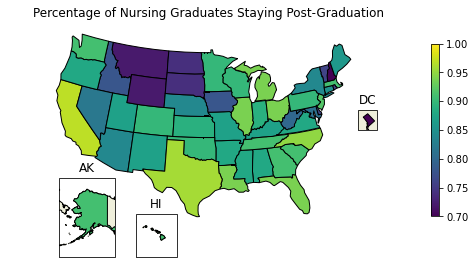

In [7]:
st_list =df_2018['ED_NDLOC_ST_PUF'].unique()
df_gfc = pd.DataFrame(data={'grad':[df_2018.loc[lambda df:(df['ED_NDLOC_ST_PUF']==st),'RKRNWGTA'].sum() for st in st_list],
                       'first':[df_2018.loc[lambda df:(df['ED_FRN_ST_PUF']==st),'RKRNWGTA'].sum() for st in st_list],
                       'current':[df_2018.loc[lambda df:(df['PN_LOC_ST_PUF']==st),'RKRNWGTA'].sum() for st in st_list]},
                      index=st_list)
df_gfc.drop(index='.L',inplace=True)

graduated_state_axis = df_gfc['grad'].sort_values(ascending=False).index
first_state_axis = df_gfc['first'].sort_values(ascending=False).index
current_state_axis = df_gfc['current'].sort_values(ascending=False).index

"""heatmap - graduate vs first state"""
hm_gf_raw = np.zeros(shape=(df_gfc.shape[0],df_gfc.shape[0]),dtype=int) #y,x

for gsi,gs in enumerate(graduated_state_axis):
    for fsi,fs in enumerate(graduated_state_axis):  #enumerate over gsa so x and y axis will have the same order
        try:
            hm_gf_raw[gsi][fsi] =df_2018.loc[lambda df:(df['ED_NDLOC_ST_PUF']==gs)&(df['ED_FRN_ST_PUF']==fs),'RKRNWGTA'].sum()
        except:
            pass
            
#normalize by the total graduate number
hm_gf = np.zeros(shape=(df_gfc.shape[0],df_gfc.shape[0]),dtype=int)
for gsi,gs in enumerate(graduated_state_axis): 
    total = sum(hm_gf_raw[gsi,:])
    if total>0:
        hm_gf[gsi,:]=hm_gf_raw[gsi,:]/total*100;   
       
    
#report results in order

gf_stay_i = np.flip(np.argsort([hm_gf[i,i] for i in range(df_gfc.shape[0])]))

print("Percentage of graduates staying after graduation")
print("------------------------------------------------")

report = ''
for i in range(df_gfc.shape[0]):
    report+='{}: {}%      '.format(graduated_state_axis[gf_stay_i[i]],hm_gf[gf_stay_i[i],gf_stay_i[i]])
    if i%4 == 3:
        print(report)
        report = ''
else:
    if i%4 != 3:
        print(report)

region_explain()
   

#draw heatmap   
map_data = {}
cmap = plt.cm.get_cmap('viridis')
data_range = [0.7, 1]
map_title = 'Percentage of Nursing Graduates Staying Post-Graduation'
for i in range(df_gfc.shape[0]):
    stname = graduated_state_axis[i]
    if stname in region.keys():
        for st in region[stname]:            
            map_data[st]=cmap((hm_gf[i,i]-70)/30)
    else:
        map_data[stname]=cmap((hm_gf[i,i]-70)/30)   


from us_map import make_map
make_map(map_data,cmap,data_range,map_title)

As expected, all states(except DC) got majority of their own graduates to stay for their first jobs. So first recommendation for any state is to
**increase the number of nursing students in the state**

Weighting by the total graduates of each state(as we did above) gives us a origin centric metric: it measures the percentage of graduates from each state(origin) that will go to a particular state(destination). If we normalize by first licensed state, it will give a destination centric metric: for each state's nursing population, it will tell us where they graduated from.

If we are interested in boosting the first-time nursing population of a state by attracting more nurses from other regions, we do not care about the destination of this state's graduates, but rather the origins of the state's nursing population. i.e. If many first time nurses in NJ went to nursing school in PA, NJ may decide to redouble their recruiting efforts in PA. Here is a heatmap of this destination centric metric.

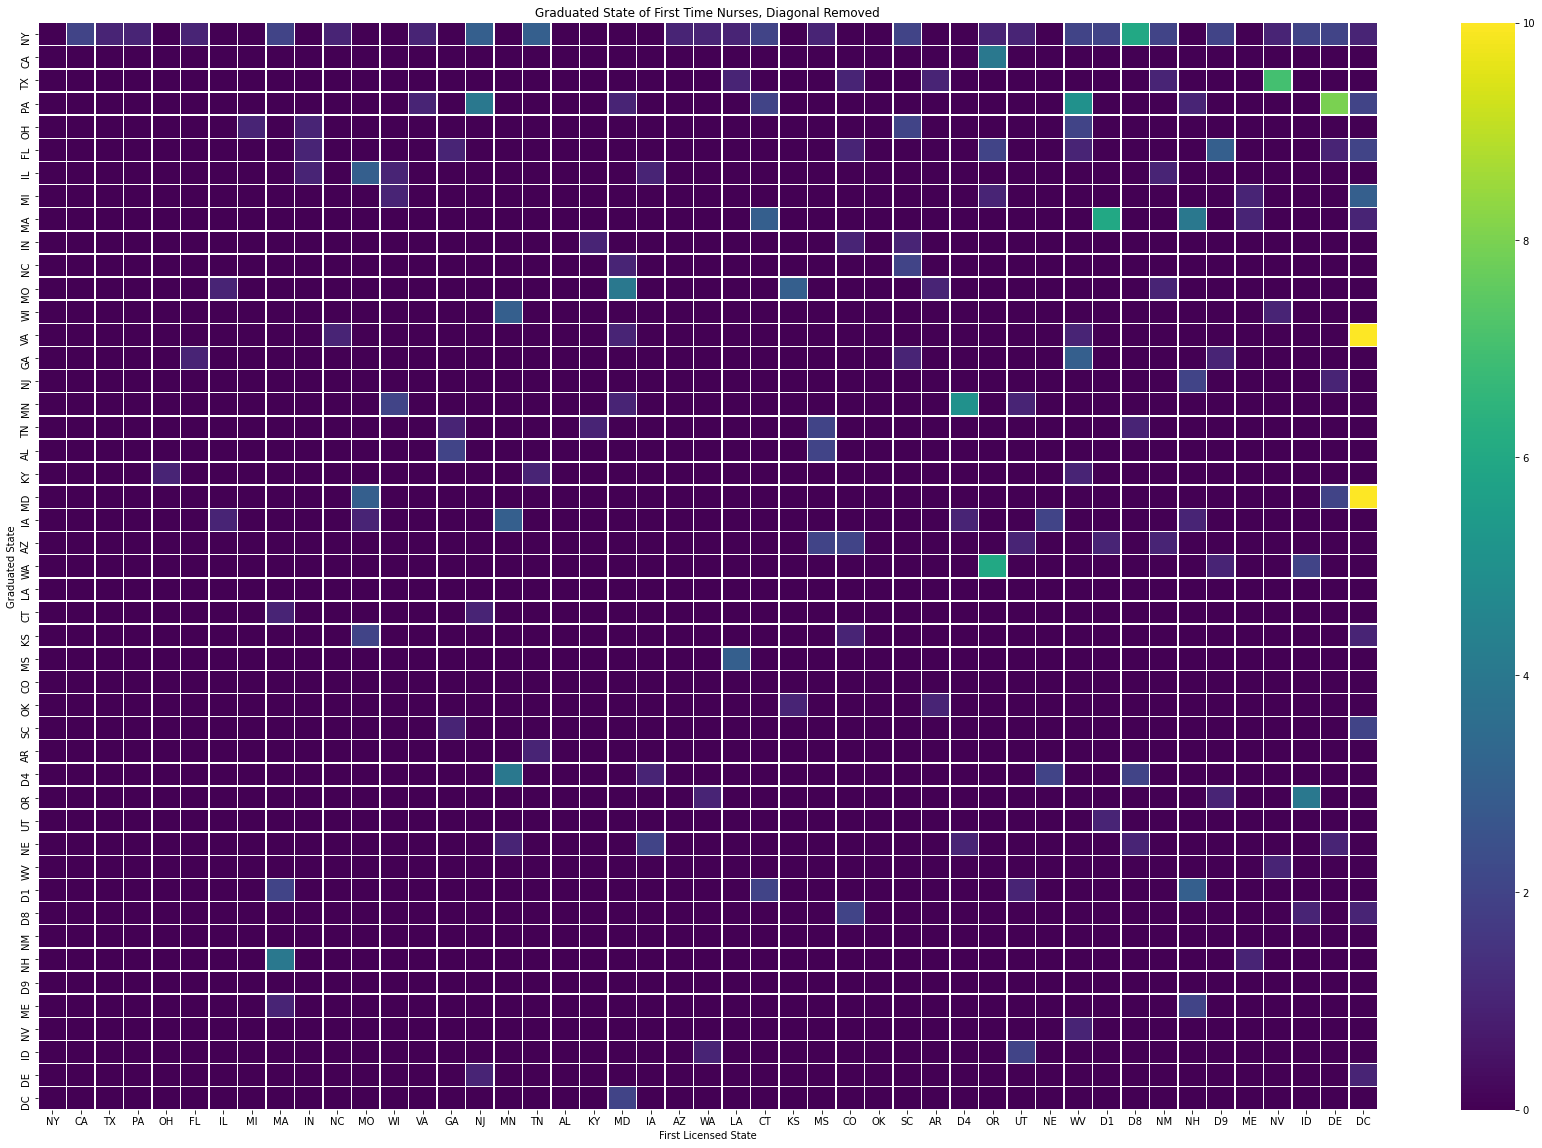

 
(D1: VT, RI     D2: ND,SD      D8: MT, WY     D9: HI, AK)


In [8]:
hm_fg = np.zeros(shape=(df_gfc.shape[0],df_gfc.shape[0]),dtype=int)
for gsi,gs in enumerate(graduated_state_axis): 
    total = sum(hm_gf_raw[:,gsi])
    if total>0:
        hm_fg[:,gsi]=hm_gf_raw[:,gsi]/total*100;

hm_fg_diag = copy.deepcopy(hm_fg)

for i in range(df_gfc.shape[0]):
    hm_fg_diag[i,i]=0
        
fig2, ax2 = plt.subplots(figsize=(30,20))
ax2 = sns.heatmap(hm_fg_diag, linewidth=0.5,cmap="viridis",xticklabels=graduated_state_axis,yticklabels=graduated_state_axis,vmin=0,vmax=10)
plt.title('Graduated State of First Time Nurses, Diagonal Removed')
plt.xlabel("First Licensed State")
plt.ylabel("Graduated State")
plt.show()  

region_explain()

Looking at few standouts, it certainly seems that geographic distance plays a big role in nursing graduates deciding to cross state borders. i.e. DC gets lots of nurses from MD and VA, OR from WA, MN from the Dakotas. We can measure the degree to which geographic distance plays a role in nurses' decisions to move states, by finding the average distance of out-of-state graduate nurses for each state. For a given state, higher average distance moved will generally signify how attaractive that state is to nurses, as it is able to attract people from far away.

Average Distance Moved by Out-of-State Graduates (mi)
------------------------------------------------
D9: 2156 mi     CA: 1021 mi     WA:  875 mi     AZ:  868 mi     
NV:  868 mi     D8:  782 mi     OR:  674 mi     NM:  669 mi     
UT:  666 mi     TX:  602 mi     FL:  589 mi     CO:  509 mi     
ID:  489 mi     ME:  463 mi     OK:  438 mi     MI:  424 mi     
AL:  415 mi     MS:  407 mi     AR:  389 mi     NY:  383 mi     
D1:  351 mi     TN:  338 mi     NE:  337 mi     GA:  331 mi     
VA:  328 mi     MO:  320 mi     LA:  312 mi     WV:  305 mi     
NC:  305 mi     D4:  302 mi     SC:  298 mi     MD:  297 mi     
OH:  247 mi     IA:  247 mi     IN:  244 mi     MN:  238 mi     
KS:  236 mi     IL:  229 mi     WI:  224 mi     NH:  223 mi     
PA:  215 mi     KY:  210 mi     NJ:  192 mi     DE:  187 mi     
DC:  173 mi     MA:  150 mi     CT:  148 mi     
 
(D1: VT, RI     D2: ND,SD      D8: MT, WY     D9: HI, AK)


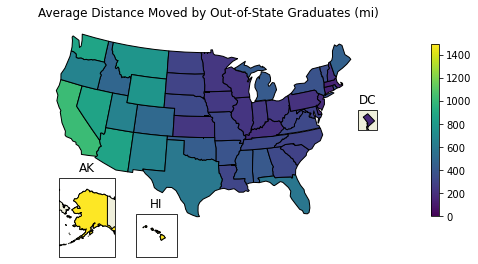

In [9]:
from distance import distance
from distance import midpoint

#function to get locations of states and regions (weighted by population for regions)
def locate(st):
    if st in region.keys():
        loc1 = state_census.loc[region[st][0],['LATITUDE','LONGITUDE']].to_numpy()
        loc2 = state_census.loc[region[st][1],['LATITUDE','LONGITUDE']].to_numpy()
        pop1 = state_census.loc[region[st][0],['POPULATION']]
        pop2 = state_census.loc[region[st][1],['POPULATION']]
        return midpoint(loc1,loc2,pop1,pop2)
    else:
        return state_census.loc[st,['LATITUDE','LONGITUDE']].to_numpy()



avg_dist = {}

for fsi,fs in enumerate(graduated_state_axis):  #we iterate fs over gs because the hm_gf array was with gs indices

    n_total = sum(hm_gf_raw[:,fsi])-hm_gf_raw[fsi,fsi]
    dist_total = 0    
    fsloc = locate(fs)
    
    for gsi, gs in enumerate(graduated_state_axis):
        if gs != fs:
            gsloc = locate(gs)
            dist_total += distance(fsloc,gsloc)*hm_gf_raw[gsi,fsi]
 
    avg_dist[fs] = dist_total/n_total*0.621371

# report text
dist_i = np.flip(np.argsort(list(avg_dist.values())))

print("Average Distance Moved by Out-of-State Graduates (mi)")
print("------------------------------------------------")

report = ''
for i in range(df_gfc.shape[0]):
    report+='{}: {:4.0f} mi     '.format(graduated_state_axis[dist_i[i]],avg_dist[graduated_state_axis[dist_i[i]]])
    if i%4 == 3:
        print(report)
        report = ''
else:
    if i%4 != 3:
        print(report)
region_explain()

#draw map
map_data = {} #colors
cmap = plt.cm.get_cmap('viridis')
data_range = [0, 1500]
map_title = 'Average Distance Moved by Out-of-State Graduates (mi)'
for i in range(df_gfc.shape[0]):
    stname = graduated_state_axis[i]
    if stname in region.keys():
        for st in region[stname]:            
            map_data[st]=cmap(avg_dist[stname]/1500)
    else:
        map_data[stname]=cmap(avg_dist[stname]/1500)   
        
from us_map import make_map
make_map(map_data,cmap,data_range,map_title)

D9 have by far the largest distance moved, but this does not accurately reflect its attractiveness to nurses, as they are not in the US mainland.

The northeast seem to have shorter average distance moved. However,the northeast also happens to have higher population density. Densely populated areas will tend to have shorter average distance, while sparsely populated areas will tend to have larger average distance (as evidenced by the west coast and D9). We can correct for this by calculating a *nearby population density*.

I define for a state n, the nearby population density *NPD* to be:

   \begin{equation} NPD = \sum_{m \neq n} \frac{population_m}{distance_{nm}^2} \end{equation}

Since there is an inverse relationship between NPD and average distance moved, we can linearize by plot 1/NPD vs. average distance:

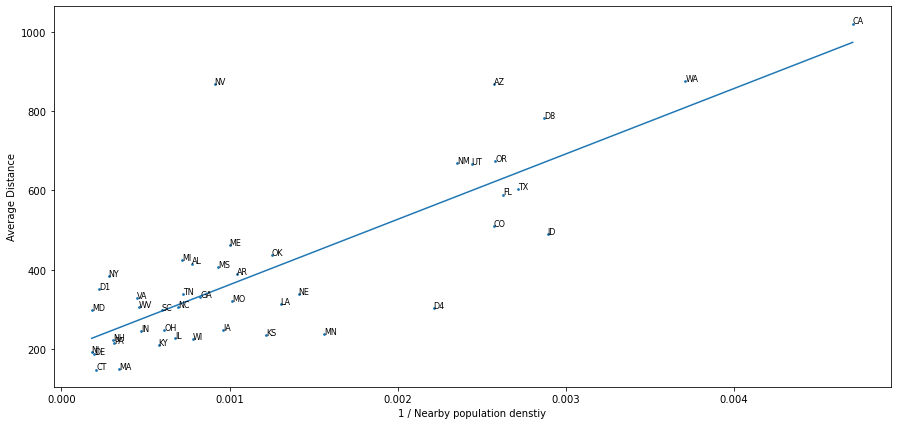

In [10]:
from scipy.optimize import curve_fit
#weight by distance^2 and plot scatter
nearby_population_density = {}

for st in state_census.index:
    density = 0
    for st_nearby in state_census.index:
        if st_nearby != st:
            dist = distance(locate(st),locate(st_nearby))
            density+= state_census['POPULATION'][st_nearby]/(dist**2)
    nearby_population_density[st] = density
    
fig, ax = plt.subplots(figsize=(15,7))
xlist=[1/s2r(nearby_population_density)[st] for st in graduated_state_axis if (st!='DC')&(st!='D9')]
ylist=[avg_dist[st] for st in graduated_state_axis if (st!='DC')&(st!='D9')]
ax.scatter(xlist,ylist,s=3)
ax.set_xlabel('1 / Nearby population denstiy')
ax.set_ylabel('Average Distance')
for i, txt in enumerate([st for st in graduated_state_axis if (st!='DC')&(st!='D9')]):
    ax.annotate(txt, (xlist[i], ylist[i]),fontsize=8)
    
z= stats.linregress(xlist,y=ylist)
xp = np.linspace(min(xlist),max(xlist),100)
yp = z.slope*xp+z.intercept
ax.plot(xp,yp)   

States above the line of best fit, such as NV, gets their out-of-state nurses from far away states rather than from nearby states. So to boost the nurses in NV with OOS nurses, NV may redouble its efforts in states that send alots of nurses to it (NY, TX, WI, as can be seen in the heatmap), or decide to recruit more from the nearby states, from which NV is not getting much input (Like CA, which has huge population but no nurses crossing into NV).

## Retainment: a Bayesian Analysis

We have so far mostly looked at how to attact more nurses from other states. The next question is "How can we retain more nurses that already work here?". We can look at how many nurses leave a state each year, but that does not tell the whole story. For example, lots of people want to live in CA, NY and other large populated states. Nurses are no exception to this. So, a state might do all the right things to attact nurses, but still see many nurses leaving to other states, and vice versa. This muddies up evaluation of policy effectiveness, so we must control for it.

To do so, I will calculate a metric I will call "disaffinity". Disaffinity is the ratio between the percentage of nurses who leave a particular state to percentage of general public that leave the same state. For example, if 2% of general population left NY in a given year and 4% of nurses left NY, then the disaffinity of NY would be 2. To do so, we need data on how people move from state to state in a given year, for which we turn to the US census (https://www.census.gov/data/tables/time-series/demo/geographic-mobility/state-to-state-migration.html).

We can use Bayesian statistics to estimate disaffinity for each state. Unfortunately, we do not have enough data to calculate this metric for each year (which would enable us to see trends), so we are going to calculate it for years 2005~2015. We will be using the PyMC3 package to build the MCMC model.

In [11]:
def r2slist(st):
    if st in region:
        return region[st]
    else:
        return [st]

movement = {}; #dictonary indexed by year, contains the data for population movement between states
desirability = {};
stname = pd.DataFrame({'STNAME':state_census.STNAME,'di_raw' : np.zeros(51,dtype=int),'oi_raw' : np.zeros(51,dtype=int)}) #oi: origin index, di: destination index

for year in range(2005,2020):
    
    migrate_raw = pd.read_excel('state_migration\\state_to_state_migrations_table_{}.xls'.format(year)).to_numpy()
    move = np.zeros(shape=[47,47]) #50 states + DC
    des = np.zeros(shape=[47,47])
    err = np.zeros(shape=[47,47])
    
    #first, find the column indexes for the origin states
    temp_st=migrate_raw[5,:]
    for i, val in enumerate(temp_st):           #remove leadign and trailing whitespace
        if isinstance(val, str):
            temp_st[i] = val.strip()            
    for si,state in stname.STNAME.items():
        stname.loc[si,'oi_raw']=np.where(temp_st==state)[0][0]     
    
    #do same for destination states
    temp_st=migrate_raw[:,0]
    for i, val in enumerate(temp_st):           #remove leadign and trailing whitespace
        if isinstance(val, str):
            temp_st[i] = val.strip()            
    for si,state in stname.STNAME.items():
        stname.loc[si,'di_raw']=np.where(temp_st==state)[0][0]            
  
    #put in the values
    for di, ds in enumerate(graduated_state_axis):
        for oi,os in enumerate(graduated_state_axis):
            for dst in r2slist(ds):
                for ost in r2slist(os):
                    num = migrate_raw[stname.di_raw[dst],stname.oi_raw[ost]]
                    if not np.isnan(num):
                        move[di,oi] += migrate_raw[stname.di_raw[dst],stname.oi_raw[ost]]
           
        
    #data format changes from 2009 to 2010, so check for that
    if year>=2010:
        #put in the stationary pop
        for di, ds in enumerate(graduated_state_axis):
            move[di,di] += sum([migrate_raw[stname.di_raw[dst],1] for dst in r2slist(ds)])-np.nansum(move[di,:])
            
    #add to dictionary
    movement[str(year)] = pd.DataFrame(move, index=graduated_state_axis, columns=graduated_state_axis)
    
    #desirability matrix
    o_total = np.nansum(move,axis=0) #total population in the origin
    for di in range(47):
        for oi in range(47):
            if move[oi,di]==0:
                if move[di,oi]==0:
                    des[di,oi]=1
                else:
                    des[di,oi] = None
            else:
                des[di,oi] = (move[di,oi]/o_total[oi])/(move[oi,di]/o_total[di])

    desirability[str(year)] = pd.DataFrame(des, index=graduated_state_axis, columns=graduated_state_axis)


In [ ]:
p_list=[]

for si, state in enumerate(graduated_state_axis):
    
    fs_data = df_2018.loc[lambda df:(df['ED_NDLOC_ST_PUF']==state)&(df['ED_NDGRAD_YR_PUF']>=2004),['ED_FRN_ST_PUF','ED_NDGRAD_YR_PUF','RKRNWGTA']] #first state, graduation year and weight
    outcome = fs_data['ED_FRN_ST_PUF'].to_numpy()!=state

    
    lam = dict.fromkeys(movement.keys(),[]) #probability that people will move from 'state' to other state
    for yr in lam:
        total = movement[yr].loc[:,state].sum()
        stay = movement[yr].loc[state,state]
        lam[yr] = 1-(stay/total)
    
    theta = np.zeros(outcome.shape) #the base rate at which all people leave the state
    for i,row in fs_data.iterrows():
        year = int(row['ED_NDGRAD_YR_PUF']+1)        #+1 because if you graduate in 2008 and move to a different state, that is measured in 2009 movement data
        theta[fs_data.index.get_loc(i)] = lam[str(year)]            

    with pm.Model() as model:
        # p = pm.Gamma('p', alpha=1, beta=1)
        p = pm.Gamma(state, alpha=1, beta=1)
        y = pm.Bernoulli('y', p=p*theta, observed=outcome)
        # trace = pm.sample(1000, tune=1000)
        trace=pm.sample(10000, cores=1,tune=1000)
        
    p_list.append(trace)
        
with open("state_desirability_no_weight.dill","wb") as f:
    dill.dump(p_list,f)


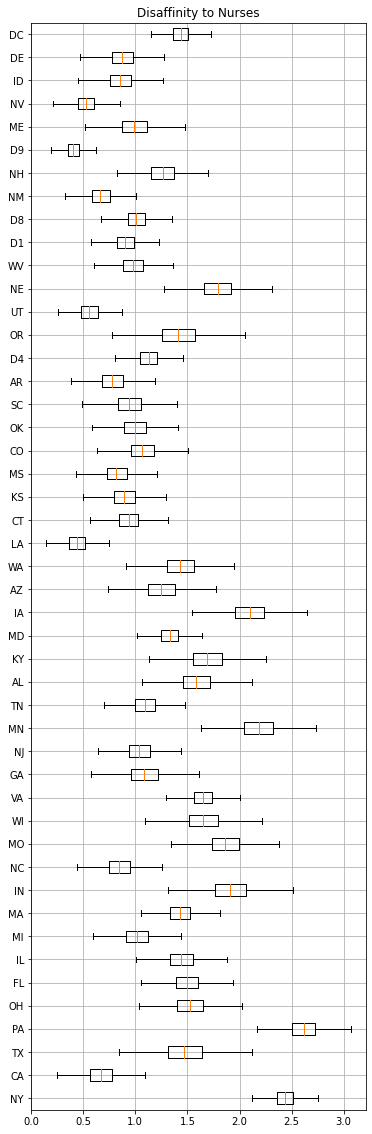

 
(D1: VT, RI     D2: ND,SD      D8: MT, WY     D9: HI, AK)


In [29]:
with open("state_desirability_no_weight.dill","rb") as f:
    p_list = dill.load(f)
    
forest_list = []
for p in p_list:
    for st in graduated_state_axis:
        try:
            forest_list.append(p[st])
        except:
            continue

            
fig1, ax1 = plt.subplots(figsize=(6,20))
ax1.boxplot(forest_list,vert=False,labels=graduated_state_axis,showfliers=False)
plt.grid()
ax1.set_title('Disaffinity to Nurses')
plt.show()

region_explain()

### Job scrapping

What factors account for the variation in disaffinity between states? We can hypothesize that perhaps the salary offered to nurses would be a great indicator. Let's scrap some salary data and see what salary distribution of states look like. The salary data was scrapped on 2/28/2001.

In [ ]:
max_entries = 2000

#mix the order to hopefully get past the captcha
itervals =[]
for st in state_census.index:
    for start in range(0, max_entries, 50):     
        itervals.append([st,start])
random.shuffle(itervals)

#also randomly choose the sleep interval by choosing lambda from normal distribution and using gillespie algorithm+1
sleep_mean = np.random.gamma(2, scale = 0.25, size=len(itervals))
sleep_rand = np.random.rand(len(itervals))
sleep_val = sleep_mean * np.log(1/sleep_rand)+0.5

#sleep_val = np.random.normal(loc=1.5, scale = 0.25, size=len(itervals))
# sns.displot(sleep_val)

salary = dict.fromkeys(state_census.index)
headers = {'User-Agent': 'Mozilla/5.0 (Linux; Android 9; SM-G960F Build/PPR1.180610.011; wv) AppleWebKit/537.36 (KHTML, like Gecko)Version/4.0 Chrome/74.0.3729.157 Mobile Safari/537.36'}

#vpn setup
instructions = initialize_VPN(area_input=['united states'])
rotate_VPN(instructions)

for i, val in tqdm(enumerate(itervals)):

    start = val[1]
    st = val[0]
    
    stn = state_census.loc[st,'STNAME']
    if len(st.split())>1:
        state = '+'.join(stn.split())
    else:
        state = stn
    url = "https://www.indeed.com/jobs?q=Registered+Nurse&l="+state+"&radius=0&jt=fulltime&limit=50&sort=date&taxo2=l1Pv1F0MQ3-LPU6ePM7Rdg&start="+str(start)
    html = requests.get(url,headers=headers)
    soup = BeautifulSoup(html.text, 'html.parser')
    
    while 'Captcha' in soup.title.text:
        #webbrowser.open('url', new=0)
        rotate_VPN(instructions)
        html = requests.get(url)
        soup = BeautifulSoup(html.text, 'html.parser')
    
    #for result in soup.find_all('span', {'class':'salaryText'}):
    for result in soup.find_all('span', {'class':'salary-snippet'}):
        if salary[st] is None:
            salary[st]=[result.text]
        else:
            salary[st].append(result.text)   
        
        # print(result.text)  
    if sleep_val[i]>0:
        sleep(sleep_val[i])
    else:
        sleep(2)
        
with open("salary_scrap.pkl","wb") as f:
    pickle.dump(salary,f)

In [15]:
with open("salary_scrap.pkl","rb") as f:
    salary = pickle.load(f)

nlp = spacy.load("en_core_web_md")
timenames = ['week','wk','year','yr','day','hour','hr','month']

paydata=dict.fromkeys(state_census.index)

for st in state_census.index:
    results = salary[st]
    
    for result in results:      
        found = 0 #find if one of the time names are in the string I collected

        for tname in timenames:
            if tname in result:
                found = 1      
                break        
        if found:
            amount = []
            doc = nlp(result)
            for token in doc:
                if token.pos_ == 'NUM':
                    try:
                        amount.append(float(token.text.replace(",", "")))
                    except:
                        pass
            if amount:
                pay = np.mean(amount)
                if tname in ['week','wk']:
                    pay = pay*52
                elif tname in ['hour','hr']:
                    pay  = pay*40*52
                elif tname =='day':
                    pay = pay*5*52
                elif tname == 'month':
                    pay = pay*12
                
                if paydata[st]:
                    paydata[st].append(pay)
                else:
                    paydata[st]=[pay]
                    

#remove outiers
paydata_clean=dict.fromkeys(state_census.index)

for st in state_census.index:
    mad = stats.median_abs_deviation(paydata[st],scale='normal')
    med_pay = np.median(paydata[st])
    paydata_clean[st] = [pay for pay in paydata[st] if abs(pay-med_pay)<3*mad]

print('Average Salary by State (dollars)')
print("------------------------------------------------")

report = ''
for i, st in enumerate(state_census.index):
    report+='{}: {:6.0f}     '.format(st,np.mean(paydata_clean[st]))
    if i%4 == 3:
        print(report)
        report = ''
else:
    if i%4 != 3:
        print(report)


Average Salary by State (dollars)
------------------------------------------------
AL:  70302     AK:  88769     AZ:  75013     AR:  66243     
CA: 108629     CO:  74529     CT:  90137     DE:  71114     
DC:  88141     FL:  82345     GA:  88211     HI: 102143     
ID:  82075     IL:  76150     IN:  68100     IA:  62136     
KS:  58905     KY:  67170     LA:  75168     ME:  76733     
MD:  87309     MA:  73120     MI:  71140     MN:  66172     
MS:  60270     MO:  74387     MT:  75331     NE:  64356     
NV: 102034     NH:  77259     NJ:  77092     NM:  76025     
NY:  85868     NC:  72259     ND:  85891     OH:  66154     
OK:  76451     OR:  82893     PA:  65737     RI:  79909     
SC:  79993     SD:  64016     TN:  68319     TX:  89729     
UT:  75076     VT:  74817     VA:  74154     WA:  93775     
WV:  61801     WI:  75351     WY:  60783     


Salary maybe not directly comparable due to two reasons.

1. Cost of living differs between states, which also affects the salary level (i.e. 130k job in San Fransico is not the same as 130k job in rural areas)
2. Progressive taxation rescales the salary (i.e. moving to a region with twice the cost of living, one must earn more than twice their original salary to maintain buying power)

To account for this, we can calculate the adjusted salary by dividing after-tax salary by the cost of living index. Doing so will give the buying power offered by a position. Then, we can do a linear regression on the raw salary and the adjusted salary versus the disaffinity values we calculated.

2 different dataset will be used to do the regression. One is the median set, where we are taking one data point per state, taking the median from the distribution. The other is the bootstrapped dataset, where I sample randomly from the salaray data, as well as the disaffinity distribution.

Sources:

    Cost of living: https://meric.mo.gov/data/cost-living-data-series
    Tax bracket: https://www.irs.gov/newsroom/irs-provides-tax-inflation-adjustments-for-tax-year-2021

Median Income Index
post-tax salary / cost of living Index
------------------------------------------------
AL: 645    AK: 570    AZ: 618    AR: 586    
CA: 574    CO: 612    CT: 584    DE: 547    
DC: 476    FL: 641    GA: 756    HI: 453    
ID: 705    IL: 689    IN: 629    IA: 583    
KS: 590    KY: 633    LA: 661    ME: 528    
MD: 546    MA: 466    MI: 683    MN: 581    
MS: 601    MO: 677    MT: 577    NE: 593    
NV: 694    NH: 557    NJ: 574    NM: 714    
NY: 483    NC: 622    ND: 707    OH: 604    
OK: 704    OR: 526    PA: 543    RI: 561    
SC: 691    SD: 558    TN: 666    TX: 746    
UT: 621    VT: 536    VA: 609    WA: 678    
WV: 531    WI: 663    WY: 503    


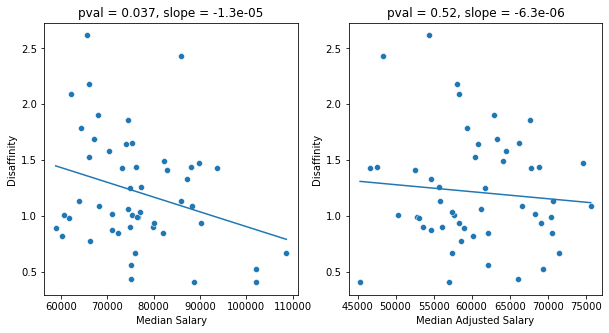

47it [01:05,  1.39s/it]


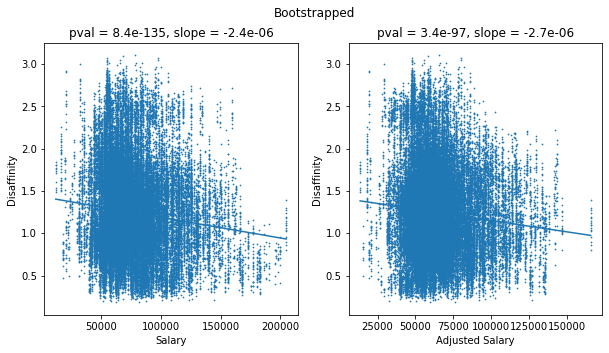

In [30]:
url = "https://meric.mo.gov/data/cost-living-data-series"
html = requests.get(url)
soup = BeautifulSoup(html.text, 'html.parser')
    
tablelist=[]
columns = []
#for result in soup.find_all('span', {'class':'salaryText'}):
table = soup.find_all('table', {'class':'table'})[1]
for row in table.findAll("tr"):
    rowlist=  []
    for cell in row.findAll("td"):
        try:
            rowlist.append(float(cell.text.strip()))
        except:
            rowlist.append(cell.text.strip())  
    tablelist.append(rowlist)
    
for header in table.findAll("th"):
    columns.append(header.text.strip())  

vallist = np.delete(np.array([row[2:] for row in tablelist[1:53]]),28,0)
stlist =  np.delete(np.array([row[1] for row in tablelist[1:53]]),28,0)

for i in range(vallist.shape[0]):
    statename = stlist[i].strip()
    stlist[i] = stname.index[stname.STNAME==statename][0]
    
col_df = pd.DataFrame(vallist,index=stlist,columns = columns[2:])
    
"""
Tax model and cost of living to normalize wages
compare this to how much people hate that state
"""


from tax_bracket import tax_bracket

print('Median Income Index')
print('post-tax salary / cost of living Index')
print("------------------------------------------------")

report = ''
for i, st in enumerate(state_census.index):
    report+='{}: {:.0f}    '.format(st,np.median(tax_bracket(paydata_clean[st]))/col_df.loc[st,'Index'])
    if i%4 == 3:
        print(report)
        report = ''
else:
    if i%4 != 3:
        print(report)

        
"""regression"""
state_to_plist = []
for st in state_census.index:
    p_st = st
    
    if st in graduated_state_axis:
        i = np.nonzero(graduated_state_axis==st)[0][0]
    else:
        for key in region:
            if st in region[key]:
                p_st = key
                i = np.nonzero(graduated_state_axis==key)[0][0]
    state_to_plist.append((i,p_st))


df_salary = pd.DataFrame({'salary':[np.mean(paydata_clean[st]) for st in state_census.index],
                         'CoL':[col_df.loc[st,'Index'] for st in state_census.index],
                         'adjusted':[100*np.median(tax_bracket(paydata_clean[st]))/col_df.loc[st,'Index'] for st in state_census.index], #income index
                         'DA':[np.median(p_list[i][p_st]) for i,p_st in state_to_plist]}, #disaffinity
                        index = state_census.index)

xvars = ['salary','adjusted']
xlabels = ['Median Salary', 'Median Adjusted Salary']

z = [stats.linregress(df_salary.salary,df_salary.DA), stats.linregress(df_salary.adjusted,df_salary.DA)]
xp = [np.linspace(min(df_salary.salary),max(df_salary.salary),10000), np.linspace(min(df_salary.adjusted),max(df_salary.adjusted),10000)]
yp = [z[i].slope*xp[i]+z[i].intercept for i in range(2)]

fig, ax = plt.subplots(1,2,figsize=(10,5))
for i in range(2):
    sns.scatterplot(data=df_salary,x=xvars[i],y='DA',ax=ax[i])
    sns.lineplot(x=xp[i],y=yp[i],ax=ax[i])
    ax[i].set_title('pval = {:.2}, slope = {:.2}'.format(z[i].pvalue,z[i].slope))
    ax[i].set_xlabel(xlabels[i])
    ax[i].set_ylabel('Disaffinity')
plt.show()





""" bootstrapping """
n_sample = 1000
boot = np.zeros(shape=[len(graduated_state_axis)*1000,3]) #[p drawn from p_list,salary drawn from adjusted]

counter=0
for i, st in tqdm(enumerate(graduated_state_axis)):
    if st in region:
        salary=[]
        for s in region[st]:
            salary.extend(paydata_clean[s])
    else:
        salary = paydata_clean[st]
    #remove outliers from p
    DA_vals = p_list[i][st]
    mad = stats.median_abs_deviation(DA_vals,scale='normal')
    med_p = np.median(DA_vals)
    clean_p = [val for val in DA_vals if abs(val-med_p)<3*mad]
    #clean_p = p_list[i].p
    for ii in range(n_sample):
        boot[counter,0] = np.random.choice(clean_p)
        boot[counter,1] = np.random.choice(salary)
        boot[counter,2] = 100*tax_bracket([boot[counter,1]])/np.mean([col_df.loc[s,'Index'] for s in r2slist(st)])
        counter+=1

    
z = [stats.linregress(boot[:,1],boot[:,0]),stats.linregress(boot[:,2],boot[:,0])]
xp =[np.linspace(min(boot[:,1]),max(boot[:,1]),10000),np.linspace(min(boot[:,2]),max(boot[:,2]),10000)]
yp = [z[i].slope*xp[i]+z[i].intercept for i in range(2)]

xlim = [(50000,120000),(400,800)]
xlabels = ['Salary', 'Adjusted Salary' ]
fig, ax = plt.subplots(1,2,figsize=(10,5))
for i in range(2):
    ax[i].scatter(boot[:,i+1],boot[:,0],s=0.5)
    sns.lineplot(x=xp[i],y=yp[i],ax=ax[i])
    ax[i].set_title('pval = {:.2}, slope = {:.2}'.format(z[i].pvalue,z[i].slope))
    ax[i].set_xlabel(xlabels[i])
    ax[i].set_ylabel('Disaffinity')
fig.suptitle('Bootstrapped')
plt.show()




So, there definitely is an inverse relation between both salaries and disaffinity, but the raw salary is a much better predictor (smaller p value).

We can now collect other state-level measures that may predict the disaffinity, and build a predictive model. Analyzing the model will allow us to pinpoint metrics that can reduce disaffinity, and thereby make it more likely to retain nurses in a state